In [1]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import display, HTML

import requests
import pickle

In [2]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow", "not "]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))

In [3]:
# functions for finding the last positive result and last negative result
def last_pos(loc_id, date):
    last_pos_date = data[(data.loc_id == loc_id) & (data.status==1) & (data.date < date)].date.max()
    if pd.isna(last_pos_date):
        return 1000
    return (date - last_pos_date).days
    
def last_neg(loc_id, date):
    last_neg_date = data[(data.loc_id == loc_id) & (data.status==0) & (data.date < date)].date.max()    
    if pd.isna(last_neg_date):
        return 1000
    return (date - last_neg_date).days

In [6]:
data=pd.read_csv("guthook_data/PCTWater-wpts-Comments.csv").rename(columns=
    {
        "Date":"date",
        "WptId":"loc_id",
        "WptName":"name",
        "Latitude":"lat",
        "Longitude":"lon",
        "Comment":"description",
        "PCT Mile": "mile"
    })

In [7]:
data

date           loc_id                   name       lat  \
0      2015/03/11  LAGstream002     Stream & Tentsite (5)  32.60690   
1      2015/03/17  LAGstream002     Stream & Tentsite (5)  32.60690   
2      2015/04/26  LAGstream002     Stream & Tentsite (5)  32.60690   
3      2015/05/05  LAGstream002     Stream & Tentsite (5)  32.60690   
4      2015/05/30  LAGstream002     Stream & Tentsite (5)  32.60690   
...           ...           ...                       ...       ...   
35116  2019/08/17  CANwaterh3_6349  Seasonal Stream        48.99746   
35117  2019/08/24  CANwaterh3_6349  Seasonal Stream        48.99746   
35118  2019/08/27  CANwaterh3_6349  Seasonal Stream        48.99746   
35119  2019/09/04  CANwaterh3_6349  Seasonal Stream        48.99746   
35120  2019/09/14  CANwaterh3_6349  Seasonal Stream        48.99746   

             lon    mile  Elevation(m)  \
0     -116.48554  2.7     732.6          
1     -116.48554  2.7     732.6          
2     -116.48554  2.7     732.6          
3     -116.48554  2.7     732.6          
4     -116.48554  2.7     732.6          
...          ...  ...       ...          
35116 -120.80044  2652.7  1369.6         
35117 -120.80044  2652.7  1369.6         
35118 -120.80044  2652.7  1369.6         
35119 -120.80044  2652.7  1369.6         
35120 -120.80044  2652.7  1369.6         

                                                      description  
0      Dry by Haiku 3/1/15                                         
1      Dry 3/7/15 Haiku                                            
2      Dry 4/22/15 Blaize                                          
3      Dry 5/5/15 ray                                              
4      Dry 5/25/15 Tuna Helper                                     
...                        ...                                     
35116  Flowing                                                     
35117  Good flow                                                   
35118  Flowing                                                     
35119  Good clear flow\r\n-- Danger Poles\r\n@rockyedgeadventures  
35120  Good flow (Smalls)                                          

[35121 rows x 8 columns]

In [8]:
data.date = pd.to_datetime(data.date)

In [9]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [10]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [11]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["decision"] = data.flowing|data.not_flowing
data["status"] = data.flowing.astype(float)

In [15]:
# remove all data with no decision
data = data[data.decision]

In [12]:
loc_ids = data.groupby("loc_id").nunique().sort_values(by="description", ascending=False)[:20].index.values

In [13]:
data = data[data.loc_id.isin(loc_ids)]

In [14]:
data["prob_exp"] = data.apply(lambda row: data[row.loc_id == data.loc_id].status.mean(), axis=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.loc_id, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.loc_id, row.date), axis=1)

In [35]:
try:
    f = open('rain_memo_coords.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    rain_memo = {}

def getRainfall(lat, lon, unix_time):
    lat, lon = round(lat,2),round(lon,2)
    if (lat, lon, unix_time) in rain_memo:
        return rain_memo[(lat,lon, unix_time)]
    print(f"{lat},{lon},{unix_time} not found, calling DarkSky")
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat},{lon},{unix_time}?exclude=currently,minutely,hourly,alerts")
    
    try:
        rain = r.json()["daily"]["data"][0]["precipIntensity"]
        rain_memo[(lat, lon, unix_time)] = rain
    except:
        rain = 0
        print(f"Data parse error {lat},{lon},{unix_time}")
        
    f = open('rain_memo_coords.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [24]:
len(rain_memo)

23077

In [19]:
def getRainSum(lat, lon, unix_time, n):
    return 24 * sum([getRainfall(lat, lon, unix_time - (24*60*60*day)) for day in range(n)])

In [36]:
data["rain_5"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 5), axis=1)


In [26]:
data

date        loc_id                     name       lat        lon  \
113   2014-04-12  LAGstream010  Small Seasonal Stream    32.60801 -116.49900   
114   2015-03-02  LAGstream010  Small Seasonal Stream    32.60801 -116.49900   
115   2015-03-11  LAGstream010  Small Seasonal Stream    32.60801 -116.49900   
116   2015-04-26  LAGstream010  Small Seasonal Stream    32.60801 -116.49900   
117   2015-04-26  LAGstream010  Small Seasonal Stream    32.60801 -116.49900   
...          ...           ...                    ...         ...        ...   
25096 2019-08-24  CRAcabin      South Brown Mtn Shelter  42.31354 -122.26428   
25099 2019-09-12  CRAcabin      South Brown Mtn Shelter  42.31354 -122.26428   
25100 2019-09-14  CRAcabin      South Brown Mtn Shelter  42.31354 -122.26428   
25101 2019-09-17  CRAcabin      South Brown Mtn Shelter  42.31354 -122.26428   
25102 2019-09-18  CRAcabin      South Brown Mtn Shelter  42.31354 -122.26428   

         mile  Elevation(m)  \
113    4.4     727.2          
114    4.4     727.2          
115    4.4     727.2          
116    4.4     727.2          
117    4.4     727.2          
...    ...       ...          
25096  1763.3  1623.8         
25099  1763.3  1623.8         
25100  1763.3  1623.8         
25101  1763.3  1623.8         
25102  1763.3  1623.8         

                                                                                                                                                                                                                                                                                                                                                                        description  \
113    water in stream, small flow pooling in a puddle to the left of the track.                                                                                                                                                                                                                                                                                                      
114    dry 1/2/15 by daytripper                                                                                                                                                                                                                                                                                                                                                       
115    dry by haiku 3/7/15                                                                                                                                                                                                                                                                                                                                                            
116    dry 4/22/15 blaize                                                                                                                                                                                                                                                                                                                                                             
117    dry 4/22/15 blaize                                                                                                                                                                                                                                                                                                                                                             
...                   ...                                                                                                                                                                                                                                                                                                                                                             
25096  the pump is working great!  just met the man w

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report

from sklearn.model_selection import train_test_split

import time

from matplotlib import cm

import matplotlib.pyplot as plt

In [28]:
data[data.status == 0].shape[0]

166

In [29]:
data_neg_over = data[data.status == 0].sample(data[data.status == 1].shape[0], replace=True)
data_over = pd.concat([data[data.status == 1], data_neg_over], axis=0)



inputs = data_over[["rain_5","last_pos","last_neg","prob_exp"]]
labels = data_over["status"]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0)
#X_train, X_test, y_train, y_test = inputs[data.loc_id != "WR0004"], inputs[data.loc_id == "WR0004"],labels[data.loc_id != "WR0004"],labels[data.loc_id == "WR0004"]
#X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0, stratify=data.loc_id)

#display(X_test.groupby("loc_id").count())
#display(X_train.groupby("loc_id").count())
#lr = LogisticRegression(C=100, penalty="l1", class_weight="balanced").fit(X_train, y_train)
#svc = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#rf = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
dt = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

#print(f'Training score {lr.score(X_train, y_train)}')
#print(f'Training score {svc.score(X_train, y_train)}')
#print(f'Training score {rf.score(X_train, y_train)}')

#print('random forest')
#print(classification_report(y_test, rf.predict(X_test)))

print('tree')
print(classification_report(y_test, dt.predict(X_test)))


print('tree')
print(classification_report(y_test, dt.predict_proba(X_test)[:, 1] > 0.8))

print('dummy')
print(classification_report(y_test, dummy.predict(X_test)))

print('most frequent')
print(classification_report(y_test, dummy_majority.predict(X_test)))


tree
              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79       410
         1.0       0.79      0.86      0.82       441

    accuracy                           0.81       851
   macro avg       0.81      0.81      0.81       851
weighted avg       0.81      0.81      0.81       851

tree
              precision    recall  f1-score   support

         0.0       0.70      0.94      0.80       410
         1.0       0.92      0.62      0.74       441

    accuracy                           0.77       851
   macro avg       0.81      0.78      0.77       851
weighted avg       0.81      0.77      0.77       851

dummy
              precision    recall  f1-score   support

         0.0       0.50      0.53      0.51       410
         1.0       0.53      0.50      0.51       441

    accuracy                           0.51       851
   macro avg       0.51      0.51      0.51       851
weighted avg       0.51      0.51      0.51       851

mos

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


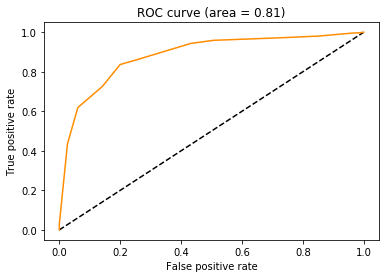

In [30]:
y_probs = dt.predict_proba(X_test)[:, 1]
y_predicted = dt.predict(X_test)

auc = roc_auc_score(y_test, y_predicted)

false_positive, true_positive, _  = roc_curve(y_test, y_probs)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc)
plt.show()

In [37]:
out = []
for loc_id in loc_ids:
    now = pd.Timestamp.now().round('1d') 
    lat = data[data.loc_id==loc_id].lat.values[0]
    lon = data[data.loc_id==loc_id].lon.values[0]
    name = data[data.loc_id==loc_id].name.values[0]
    
    result = {
        'loc_id': loc_id, 
        'lat': lat, 
        'lon': lon, 
        'name': name,
        'mile': 1
    }
    
    for days in range(4):
        prediction = dt.predict_proba([[
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 5), 
                    last_pos(loc_id, now) + days, 
                    last_neg(loc_id, now) + days,
                    data[loc_id == data.loc_id].status.mean()
                ]])
         
        result[f'prediction_{days}'] = prediction[0][1]
    
    out.append(result)

    
f = open('out_gh.pkl', 'wb')
pickle.dump(out, f)
f.close() 

40.84,-121.42,1569283200 not found, calling DarkSky
40.84,-121.42,1569196800 not found, calling DarkSky
40.84,-121.42,1569110400 not found, calling DarkSky
40.84,-121.42,1569024000 not found, calling DarkSky
40.84,-121.42,1568937600 not found, calling DarkSky
40.84,-121.42,1569369600 not found, calling DarkSky
40.84,-121.42,1569456000 not found, calling DarkSky
40.84,-121.42,1569542400 not found, calling DarkSky
42.31,-122.26,1569283200 not found, calling DarkSky
42.31,-122.26,1569196800 not found, calling DarkSky
42.31,-122.26,1569110400 not found, calling DarkSky
42.31,-122.26,1569024000 not found, calling DarkSky
42.31,-122.26,1568937600 not found, calling DarkSky
42.31,-122.26,1569369600 not found, calling DarkSky
42.31,-122.26,1569456000 not found, calling DarkSky
42.31,-122.26,1569542400 not found, calling DarkSky


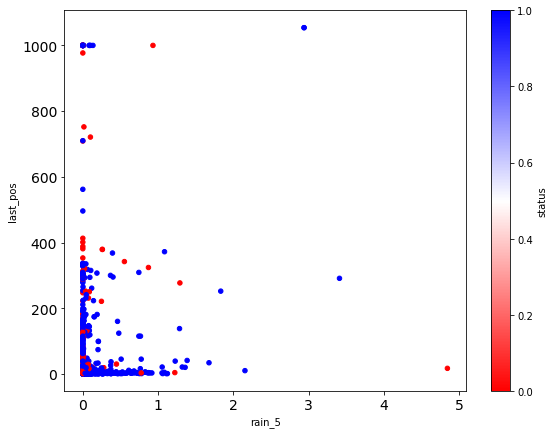

In [34]:
data.plot(kind='scatter',x="rain_5",y="last_pos",c="status", cmap=cm.get_cmap('bwr_r'), figsize=(9,7), fontsize=14)

In [33]:
dt.feature_importances_

array([ 0.0446691 ,  0.33535714,  0.12950517,  0.49046859])

In [260]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree.dot', 
                feature_names = X_test.columns,
                class_names = ["dry","wet"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')